In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F # for activation functions
from torch.optim import Adam

import lightning as L
from torch.utils.data import DataLoader, TensorDataset

In [37]:
class LSTMByHand(L.LightningModule):
  def __init__(self):
    '''
    Define all the weights and biases of each block of the LSTM unit
    '''
    super().__init__()

    mean= torch.tensor(0.0)
    std= torch.tensor(1.0)

    self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
    self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

  def lstm_unit(self, input, long_memory, short_memory):
    # first stage - % long memory to remember - forget gate
    long_memory_forget = torch.sigmoid(
        ((short_memory * self.wlr1) + (input * self.wlr2)) + self.blr1
    )

    # stage 2 - creating and adding to long term memory - input gate
    potential_remember_percent = torch.sigmoid(
        ((short_memory * self.wpr1) + (input * self.wpr2)) + self.bpr1
    )

    potential_long_memory = torch.tanh(
        ((short_memory * self.wp1) + (input * self.wp2)) + self.bp1
    )

    updated_long_memory = (potential_remember_percent * potential_long_memory) + long_memory

    # stage 3 - creating new short term memory - output gate
    output_percent = torch.sigmoid(
         ((short_memory * self.wo1) + (input * self.wo2)) + self.bo1
    )

    updated_short_memory = torch.tanh(updated_long_memory) * output_percent

    return([updated_long_memory, updated_short_memory])

  def forward(self, input):
    long_memory = 0
    short_memory = 0
    day1 = input[0]
    day2 = input[1]
    day3 = input[2]
    day4 = input[3]

    long_memory, short_memory = self.lstm_unit(day1, long_memory, short_memory)
    long_memory, short_memory = self.lstm_unit(day2, long_memory, short_memory)
    long_memory, short_memory = self.lstm_unit(day3, long_memory, short_memory)
    long_memory, short_memory = self.lstm_unit(day4, long_memory, short_memory)

    return short_memory

  def configure_optimizers(self):
    return Adam(self.parameters())

  def training_step(self, batch, batch_idx):
    input_i, label_i = batch # input is previous day, label is actual value
    output_i = self.forward(input_i[0])
    loss = (output_i - label_i) ** 2

    self.log('train loss', loss)

    if (label_i == 0):
      self.log('out_0', output_i)
    else:
      self.log('out_1', output_i)

    return loss

In [38]:
model = LSTMByHand()

## data we are using to train(very basic)
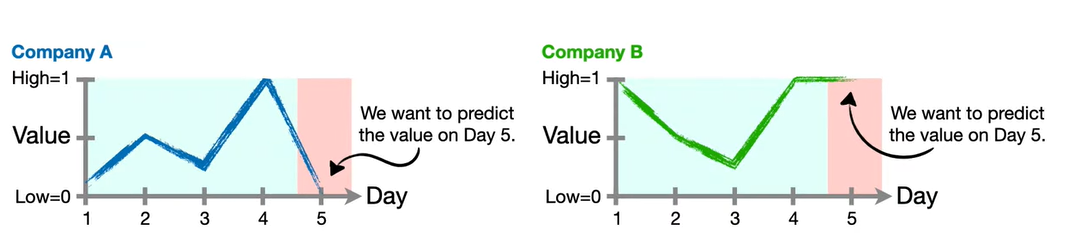

In [39]:
# creating the stock price data of the two companies(4 days of data need to predict 5th day)

inputs = torch.tensor([[0., 0.5, 0.25, 1.], [1., 0.5, 0.25, 1.]])
labels = torch.tensor([0., 1.])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [44]:
trainer = L.Trainer(max_epochs=2000)
trainer.fit(model, train_dataloaders=dataloader)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type ┃ Params ┃ Mode ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━┩
│   │ other params │ n/a  │     12 │ n/a  │   n/a │
└───┴──────────────┴──────┴────────┴──────┴───────┘

Trainable params: 12                                                                                               
Non-trainable params: 0                                                                                            
Total params: 12                                                                                                   
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 0                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO: `Trainer.fit` stopped: `max_epochs=2000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2000` reached.


In [45]:
# lets train for more epochs but start from the 2000 epoch line
# we do that by using lightning

path_to_best_checkpt = trainer.checkpoint_callback.best_model_path

# new trainer
trainer = L.Trainer(max_epochs=4000)
trainer.fit(model, train_dataloaders=dataloader, ckpt_path=path_to_best_checkpt)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=1999-step=4000.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_4/checkpoints/epoch=1999-step=4000.ckpt
/usr/local

┏━━━┳━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type ┃ Params ┃ Mode ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━┩
│   │ other params │ n/a  │     12 │ n/a  │   n/a │
└───┴──────────────┴──────┴────────┴──────┴───────┘

Trainable params: 12                                                                                               
Non-trainable params: 0                                                                                            
Total params: 12                                                                                                   
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 0                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

INFO: Restored all states from the checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=1999-step=4000.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/lightning_logs/version_4/checkpoints/epoch=1999-step=4000.ckpt


Output()

INFO: `Trainer.fit` stopped: `max_epochs=4000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4000` reached.


In [47]:
# evaluation
print("\nNow let's compare the observed and predicted values...")
print("Company A: Observed = 0, Predicted =",
      model(torch.tensor([0., 0.5, 0.25, 1.])).detach())

print("Company B: Observed = 1, Predicted =",
      model(torch.tensor([1., 0.5, 0.25, 1.])).detach())



Now let's compare the observed and predicted values...
Company A: Observed = 0, Predicted = tensor(-0.0003)
Company B: Observed = 1, Predicted = tensor(0.9939)


### observation
we can see that the company A prediction is close to 0 and B is close to 1 like the actual values.